In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from src.yolo.v1 import YOLOv1Dataset, YOLOv1, YoloLoss

from src.visualization import plot_yolo_labels
import numpy as np
from src.utils.utils import DATA_PATH, ROOT
import albumentations as A
import matplotlib.pyplot as plt
import torch

In [5]:
S = 7
B = 2
DS_NAME = "VOC"
DS_PATH = DATA_PATH / DS_NAME

# ckpt_path = ROOT / "checkpoints/best-v2.ckpt"
# ckpt = torch.load(ckpt_path)

transform = A.Compose(
    [A.Resize(448, 448)],
    bbox_params=A.BboxParams(format="yolo", label_fields=["labels"], min_visibility=0.7),
)
ds = YOLOv1Dataset(S, B, DS_PATH, transform=transform)
C = ds.C
model = YOLOv1(S, C, B)
loss_fn = YoloLoss(S, C, B)

In [6]:
img, annot = ds[0]
x = img.unsqueeze(0)

In [12]:
annot.shape

torch.Size([7, 7, 30])

In [6]:
# module = YOLODetector.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn)

In [115]:
# out = module.cpu()(img.unsqueeze(0))[0]
out = torch.cat((annot.unsqueeze(0), annot.unsqueeze(0)), dim=0)
scores_out = out[..., :C]
scores = scores_out.flatten(start_dim=1, end_dim=2)

batch_size = out.shape[0]
boxes_out = out[..., C:].reshape(batch_size, S, S, B, -1)
best_boxes_idxs = boxes_out[..., 0].argmax(-1)

index = best_boxes_idxs[..., None, None].expand(-1, -1, -1, 1, boxes_out.size(4))
best_boxes = torch.gather(boxes_out, dim=3, index=index).squeeze(3)  # S x S x B x 5 -> S x S x 5
best_boxes_xywh = best_boxes[..., 1:]

objectness = best_boxes[..., 0].flatten(start_dim=1, end_dim=-1).unsqueeze(-1)


boxes_xy_cell = best_boxes_xywh[..., :2]
boxes_wh_cell = best_boxes_xywh[..., 2:]

ij = torch.arange(7).repeat(7, 1).unsqueeze(-1).unsqueeze(0)

x = (boxes_xy_cell[..., 0:1] + ij) / S
y = 1 / S * (boxes_xy_cell[..., 1:2] + ij.permute(0, 2, 1, 3))
wh = boxes_wh_cell / S
boxes_xywh = torch.cat((x, y, wh), dim=-1)
boxes_xywh = boxes_xywh.flatten(start_dim=1, end_dim=-2)

best_class = scores.argmax(dim=-1).unsqueeze(-1)

preds = torch.cat((best_class, objectness, boxes_xywh), dim=-1)

In [116]:
preds.shape

torch.Size([2, 49, 6])

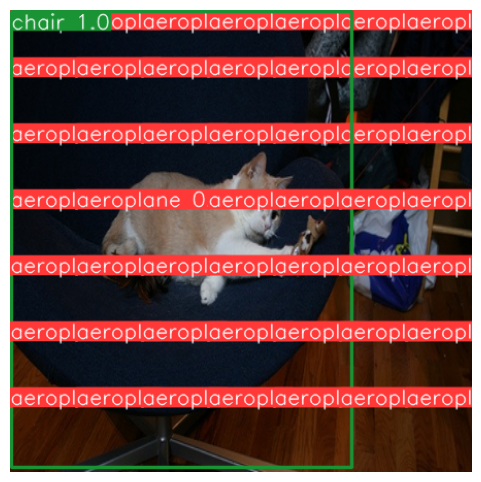

In [117]:
_ = plot_yolo_labels(
    (img.permute(1, 2, 0) * 255).detach().numpy().astype(np.uint8),
    preds[0, :, 2:].detach().numpy(),
    preds[0, :, 0].numpy(),
    preds[0, :, 1].detach().numpy(),
    plot=True,
    id2name={i: ds.labels[i] for i in range(C)},
)